In [28]:
import os
import glob

import pandas as pd
import numpy as np
import random

import matplotlib.pyplot as plt
from PIL import Image

#import torch
from torch import nn, optim, functional
from torchvision import transforms

from torchvision.utils import make_grid
from torchvision.io import decode_image

from torchvision_plotting import plot as helpers_plot
from torch.utils.data import Dataset, DataLoader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

random.seed(15)

### Import film and digital data

In [29]:
class ImageDataset(Dataset):
    def __init__(self, file_list, apply_transform = None,  film_or_digital = "digial"):
        "Apply transform must be a transform object"

        self.file_paths = file_list
        self.apply_transform = apply_transform
        self.film_or_digital = film_or_digital

    def __len__(self):
        return f"Working with {len(self.file_paths)} files"
    
    def __getitem__(self, idx):
        img_path = self.file_paths[idx]

        image = Image.open(img_path).convert("RGB")


        #Make sure to align film or digital transformations correctly"
        if self.apply_transform:
            print(f"Transforming {self.film_or_digital} images")
            image = self.apply_transform(image)
        
        return image
    


In [25]:
def dataset_splitting_preparation(data_paths, 
                                split_portions = (.80, .10, .10),
                                transforms_to_apply = None,
                                pic_type = 'digital'):
    full_amnt = len(data_paths)
    
    train_amnt = int(split_portions[0] * full_amnt)
    val_amnt = int(split_portions[1] * full_amnt)
    test_amnt = int(split_portions[2] * full_amnt)

    assert split_portions[0] + split_portions[1] + split_portions[2] == 1.0, "Train, Val, test splits do not sum to 1"
    

    random.shuffle(data_paths)

    train_data = data_paths[:train_amnt]
    val_data = data_paths[train_amnt:val_amnt + train_amnt]
    test_data = data_paths[val_amnt + train_amnt:]

    train_image_data = ImageDataset(file_list = train_data, apply_transform=transforms_to_apply, film_or_digital = pic_type)
    val_image_data = ImageDataset(file_list = val_data, apply_transform=transforms_to_apply, film_or_digital = pic_type)
    test_image_data = ImageDataset(file_list = test_data, apply_transform=transforms_to_apply, film_or_digital = pic_type)


    return train_image_data, val_image_data, test_image_data



In [ ]:
#Implementing image transformations to expand images we are using
resize_dims = (256, 256) if "device" != "cpu" else (128, 128)

film_image_transforms = nn.Sequential(
    transforms.v2.Resize(resize_dims), 
    transforms.v2.ToTensor(), 
    transforms.v2.Normalize(mean = [0.485, 0.456, 0.406],  std =[0.229, 0.224, 0.225])
)

#Implementing image transformations to expand images we are using
digital_image_transforms = nn.Sequential(
    transforms.v2.Resize(resize_dims), 
    transforms.v2.RandomHorizontalFlip(p = 0.2),
    transforms.v2.RandomVerticalFlip(p = 0.2), 
    transforms.v2.ToTensor(), 
    transforms.v2.Normalize(mean = [0.485, 0.456, 0.406],  std =[0.229, 0.224, 0.225])
)



/Users/cody_schiffer/anaconda3/envs/a-alpha-conda/lib/python3.10/site-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


In [ ]:
film_paths = "/Users/cody_schiffer/Personal_Projects/filmify!/film_photos"
film_paths = glob.glob(film_paths + "/*.jpeg") # Grabbing all the image file names

# _, axes = plt.subplots(4, 4, figsize=(10, 10))
# for ax, img_path in zip(axes.flatten(), film_paths):
#     ax.imshow(Image.open(img_path))
#     ax.axis("off")

digital_paths = "/Users/cody_schiffer/Personal_Projects/filmify!/digital_photos"
digital_paths = glob.glob(digital_paths + "/*.jpeg")

# _, axes = plt.subplots(4, 4, figsize=(10, 10))
# for ax, img_path in zip(axes.flatten(), digital_paths):
#     ax.imshow(Image.open(img_path))
#     ax.axis("off")

#Limit data for cpu testing
if device == "cpu":
    film_paths = film_paths[:50]
    digital_paths = digital_paths[:50]

split_scheme = (.80,.10,.10)

film_train, film_val, film_test = dataset_splitting_preparation(film_paths,
                                                                split_portions = split_scheme,
                                                                transforms_to_apply=film_image_transforms,
                                                                pic_type="film")
digital_train, digital_val, digital_test = dataset_splitting_preparation(digital_paths,
                                                                        split_portions = split_scheme,
                                                                        transforms_to_apply=digital_image_transforms,
                                                                        pic_type="digital")




IndentationError: expected an indented block after 'if' statement on line 18 (3103089918.py, line 20)

Film Training data
Transforming film images
Transforming film images
Transforming film images
Transforming film images
Transforming film images
Digital Training Data
Transforming digital images
Transforming digital images
Transforming digital images
Transforming digital images
Transforming digital images


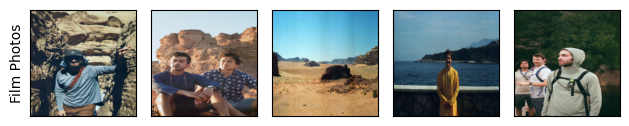

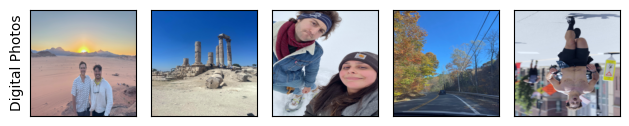

In [ ]:
#Show the image transformations
print("Film Training data")
new_images = [film_train[i] for i in range(10, 15)] 
helpers_plot(new_images, row_title = ["Film Photos"])

print("Digital Training Data")
new_images = [digital_train[i] for i in range(10, 15)]
helpers_plot(new_images, row_title = ["Digital Photos"])




In [ ]:
#Lets create our dataloaders

if device == "cpu":
    batch_size = 1 #should be hyperparameter tuned given normalization strategies
    norm_type = "instance"
else:
    batch_size = 10
    norm_type = "batch"

film_train_DL = DataLoader(film_train, batch_size = batch_size)
film_val_DL = DataLoader(film_val, batch_size = batch_size)
film_test_DL = DataLoader(film_test, batch_size=batch_size)

digital_train_DL = DataLoader(digital_train, batch_size = batch_size)
digital_val_DL = DataLoader(digital_val, batch_size = batch_size)
digital_test_DL = DataLoader(digital_test, batch_size = batch_size)
